# OpenStreetMaps (OSM) Model

## Imports

In [1]:
import sys
sys.path.insert(0, '../utils')
import model_utils
import data_utils

import pandas as pd
import numpy as np

import warnings
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import wandb
wandb.init(project="tm-poverty-prediction")

%load_ext autoreload
%autoreload 2

wandb: Currently logged in as: sabman (use `wandb login --relogin` to force relogin)


## File Locations

In [3]:
bucket_name = 'tm-geospatial'
directory = 'poverty-prediction-datasets'

# data_dir = '../data/zoom17/'
data_dir = '../data/'
ntl_summary_stats_file = data_dir+'nightlights_summary_stats.csv'
dhs_indicators_file = data_dir+'dhs_indicators.csv'

osm_roads_file = data_dir+'osm_roads.csv'
osm_buildings_file = data_dir+'osm_buildings.csv'
osm_pois_file = data_dir+'osm_pois.csv'

## Load Datasets

In [4]:
# Load DHS indicators and nighttime lights
dhs_indicators = pd.read_csv(dhs_indicators_file)
ntl_summary_stats = pd.read_csv(ntl_summary_stats_file)

# Load OSM datasets
roads = pd.read_csv(osm_roads_file)
buildings = pd.read_csv(osm_buildings_file)
pois = pd.read_csv(osm_pois_file)

# Define feature columns
road_cols = roads.columns[1:]
building_cols = buildings.columns[1:]
poi_cols = pois.columns[1:]
ntl_cols = ntl_summary_stats.columns[1:]

# Get list of columns
osm_cols = list(road_cols) + list(building_cols) + list(poi_cols)
osm_ntl_cols = list(osm_cols) + list(ntl_cols)

## Combine Features

In [5]:
# Merge roads + buildings + pois
osm = roads.merge(buildings, on='DHSCLUST')
osm = osm.merge(pois, on='DHSCLUST')
print("Shape of osm dataframe: {}".format(osm.shape))

# Merge osm + nightlights
osm_ntl = osm.merge(ntl_summary_stats, on='DHSCLUST')
print("Shape of osm+ntl dataframe: {}".format(osm_ntl.shape))

# merge dhs + osm
dhs = dhs_indicators.merge(osm_ntl, left_on='Cluster number', right_on='DHSCLUST')

Shape of osm dataframe: (1214, 146)
Shape of osm+ntl dataframe: (1214, 154)


## Spearman and Pearsons Correlation

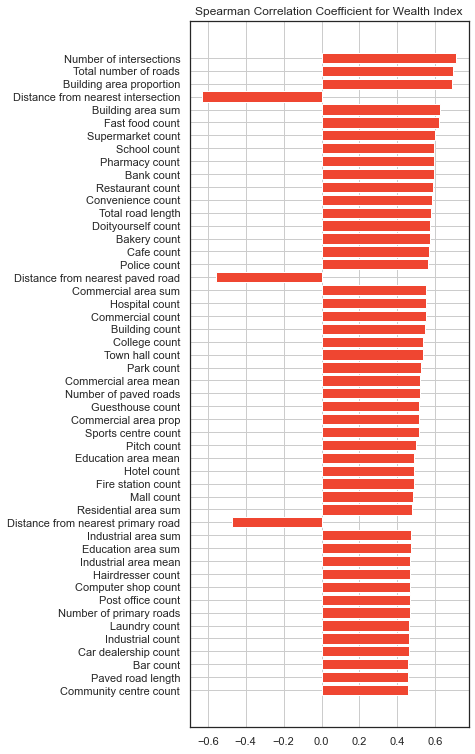

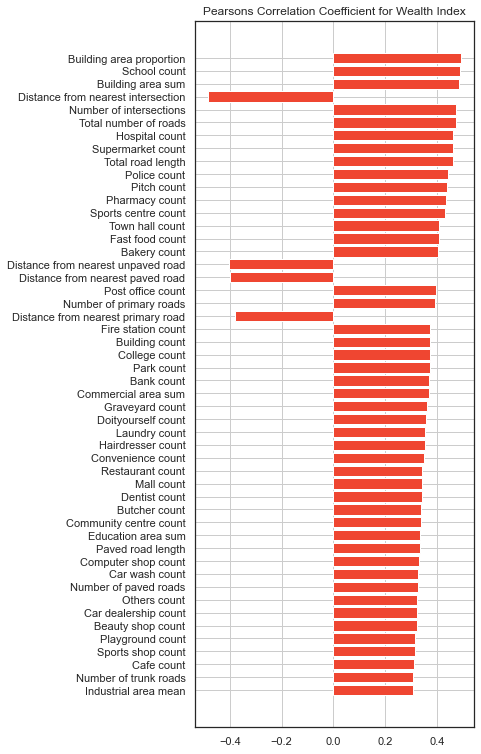

In [6]:
data_utils.plot_corr(
    data=dhs,
    features_cols=osm_cols,
    indicator = 'Wealth Index',
    max_n=50,
    figsize=(5,13)
);

## Machine Learning Pipeline

### Configuration

In [7]:
# Scoring metrics
scoring = {
    'r2': data_utils.pearsonr2,
    'rmse': data_utils.rmse
}

# Indicators of interest
indicators = [
    'Wealth Index',
    'Education completed (years)',
    'Access to electricity',
    'Access to water (minutes)'
]

## OSM Features + Nighttime Lights

In [ ]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=osm_ntl_cols, 
    indicator_cols=indicators,
    wandb=wandb,
    scoring=scoring,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=False,
    verbose=2
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


## OSM Features Only

Socioeconomic indicator: Wealth Index
fit_time : 96.5320
[96.7951858  97.32513213 97.07024193 95.6034348  95.86594296]
score_time : 0.4959
[0.64389992 0.41747618 0.42795849 0.46497273 0.52533102]
test_r2 : 0.5883
[0.59450307 0.60727197 0.58297363 0.60375808 0.55305839]
train_r2 : 0.7540
[0.74768085 0.75299858 0.75574587 0.75640448 0.75729353]
test_rmse : 45630.1195
[45988.90500582 46296.46328057 42870.31857984 46146.38527796
 46848.52525625]
train_rmse : 36217.5609
[36077.73562941 35638.15273756 36884.94820922 36160.35087123
 36326.61687552]


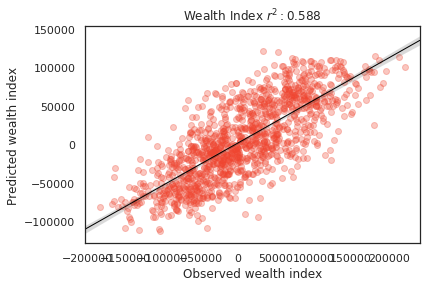

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


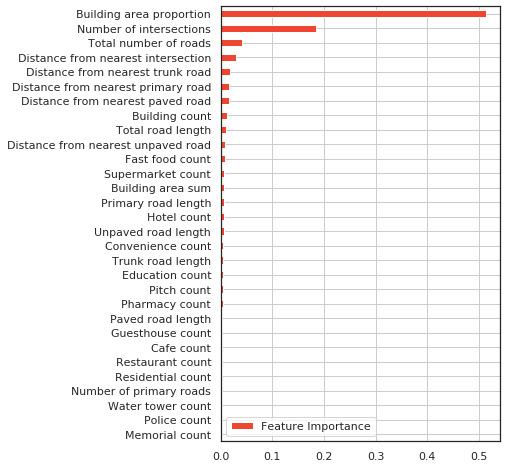

Socioeconomic indicator: Education completed (years)
fit_time : 95.8053
[95.36287546 95.66011953 95.5135355  96.6915946  95.79841542]
score_time : 0.4205
[0.42220044 0.41837454 0.42000341 0.42109752 0.42068648]
test_r2 : 0.4636
[0.48220645 0.45854176 0.39959129 0.53052792 0.44691195]
train_r2 : 0.6674
[0.66237725 0.66905462 0.67768631 0.66075018 0.66695038]
test_rmse : 1.7261
[1.63273357 1.83820256 1.78069724 1.68287048 1.69578323]
train_rmse : 1.3999
[1.42205966 1.37652709 1.3841662  1.40636319 1.41021887]


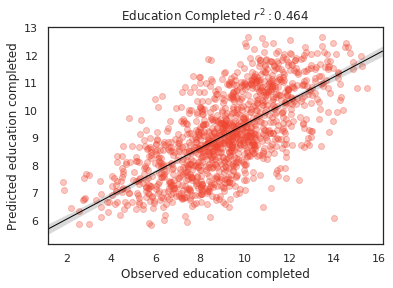

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


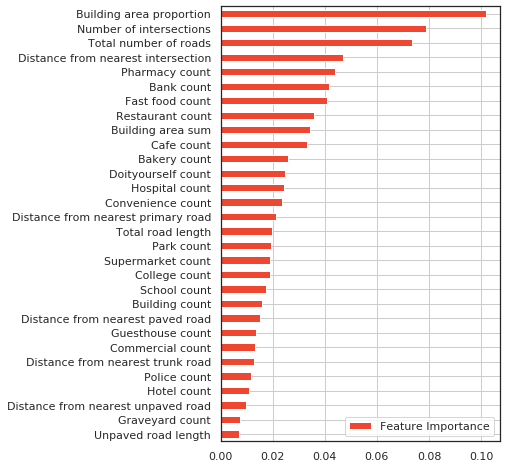

Socioeconomic indicator: Access to electricity
fit_time : 95.6793
[96.29461479 95.15748811 96.30638671 95.31303668 95.32514119]
score_time : 0.4617
[0.62147307 0.42335629 0.41982913 0.41824865 0.42561889]
test_r2 : 0.3203
[0.2900853  0.29126758 0.34279566 0.36581913 0.31159497]
train_r2 : 0.5238
[0.51998565 0.5298667  0.5228733  0.52760578 0.51879584]
test_rmse : 0.1204
[0.10021654 0.11719984 0.1267357  0.1324464  0.12558519]
train_rmse : 0.1042
[0.10949227 0.10456677 0.10272795 0.10068679 0.10337994]


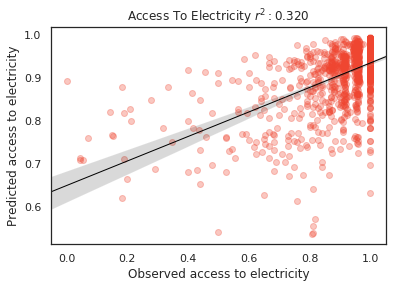

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


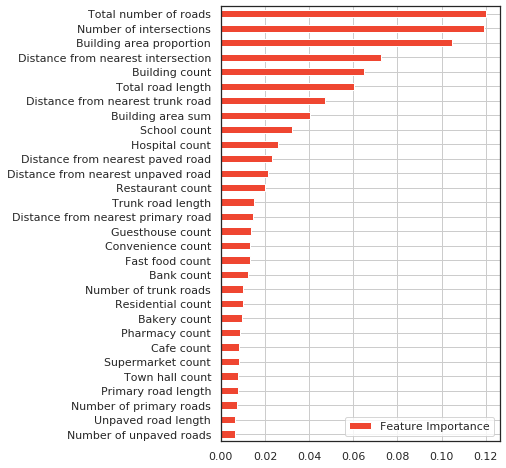

Socioeconomic indicator: Access to water (minutes)
fit_time : 94.4255
[94.49660301 95.01791668 93.37854409 94.15820456 95.07642674]
score_time : 0.5023
[0.41875339 0.4218266  0.72501135 0.42199969 0.52366161]
test_r2 : 0.0492
[0.11155539 0.0578052  0.01939557 0.0104736  0.04680941]
train_r2 : 0.3623
[0.41944692 0.31506968 0.36089821 0.30638032 0.40968386]
test_rmse : 7.8163
[12.66137682  8.06386413  6.70330831  6.12498088  5.52800111]
train_rmse : 6.9478
[5.55459101 7.33060047 7.21812758 7.35314669 7.28277649]


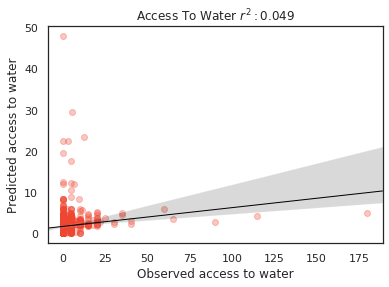

/home/issa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=7, max_features='log2',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=969, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


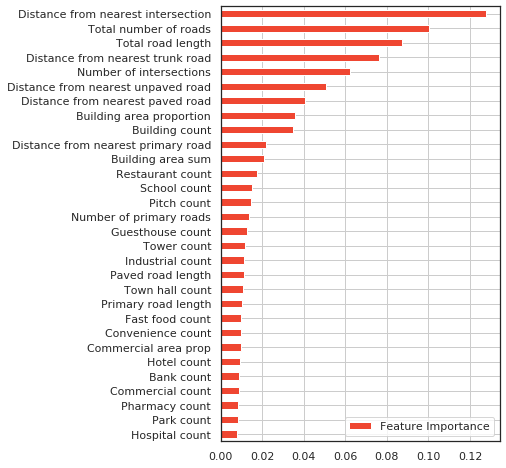

In [8]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=osm_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)

## Road Features

Socioeconomic indicator: Wealth Index
fit_time : 90.7227
[91.43233943 91.37191892 90.16479921 90.47720265 90.16701031]
score_time : 0.4207
[0.41899657 0.41948104 0.42003274 0.42101073 0.42382312]
test_r2 : 0.5494
[0.52483693 0.57239685 0.54892386 0.56635898 0.53436962]
train_r2 : 0.7743
[0.77918187 0.77616808 0.77303519 0.77384021 0.76944245]
test_rmse : 47682.5946
[49974.32622959 48256.92937517 44558.49222033 47930.32295679
 47692.90222419]
train_rmse : 34739.4074
[34222.71905797 34349.33744521 35367.28001309 34606.70901179
 35150.99145233]


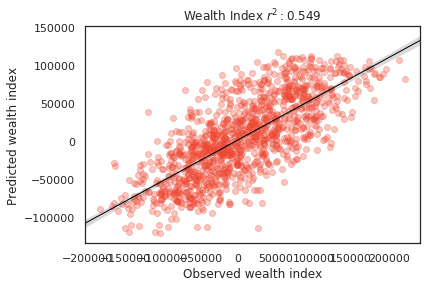

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=7, max_features='log2',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=969, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


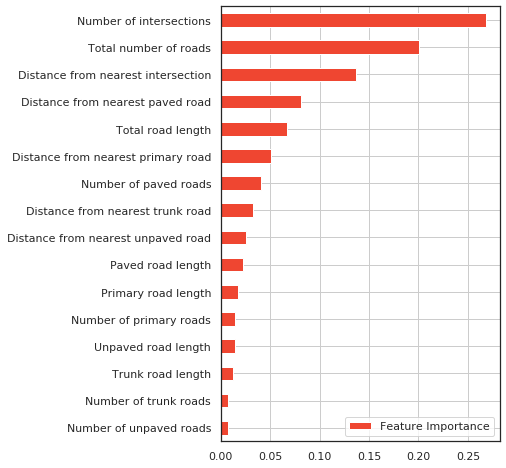

Socioeconomic indicator: Education completed (years)
fit_time : 90.6080
[90.9088366  90.5962286  91.56796503 90.11937928 89.84768391]
score_time : 0.5052
[0.42847919 0.52790689 0.62321877 0.42121124 0.52513528]
test_r2 : 0.4248
[0.41333367 0.44425431 0.36114607 0.49228033 0.41319505]
train_r2 : 0.6548
[0.71273445 0.62895596 0.52115454 0.70477885 0.70616766]
test_rmse : 1.7833
[1.74196997 1.8542204  1.83885879 1.73537016 1.74586441]
train_rmse : 1.4098
[1.3185206  1.43391394 1.64744469 1.32031501 1.32862488]


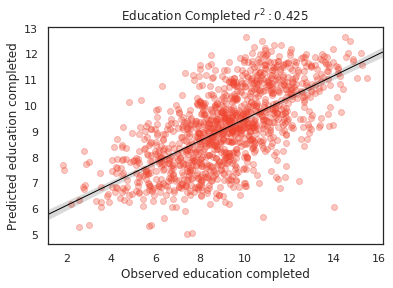

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=6, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1415, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


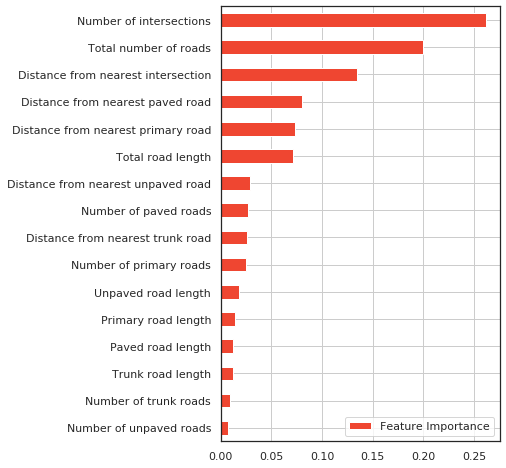

Socioeconomic indicator: Access to electricity
fit_time : 91.0076
[90.63570547 91.96869946 91.58648109 90.75311637 90.09382486]
score_time : 0.5045
[0.42326665 0.62829041 0.6236341  0.42614388 0.42134595]
test_r2 : 0.2889
[0.27197624 0.26423526 0.30087113 0.33197593 0.27526861]
train_r2 : 0.4892
[0.56977945 0.42367144 0.4157049  0.6440999  0.39262577]
test_rmse : 0.1239
[0.10719197 0.11937063 0.12957705 0.13493326 0.12850498]
train_rmse : 0.1058
[0.1028627  0.11287431 0.11068739 0.08876552 0.11375966]


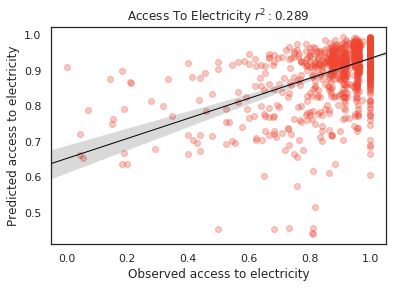

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


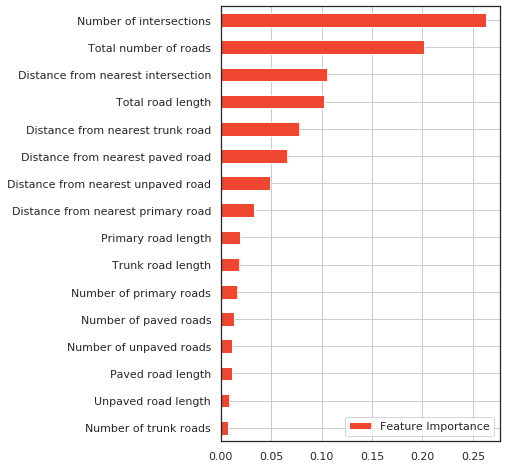

Socioeconomic indicator: Access to water (minutes)
fit_time : 88.8959
[91.1380024  87.88839078 88.6374557  88.69705105 88.11853504]
score_time : 0.4312
[0.42613792 0.45184493 0.42339301 0.41720653 0.43723011]
test_r2 : 0.0492
[0.13868705 0.05279088 0.01010914 0.02503929 0.01940175]
train_r2 : 0.4004
[0.49607607 0.38001558 0.43522787 0.3423098  0.34848716]
test_rmse : 8.1104
[12.50074506  8.06611525  6.77051712  6.46791423  6.74648316]
train_rmse : 6.5883
[5.20185347 6.70275343 6.80098126 7.1601781  7.07581617]


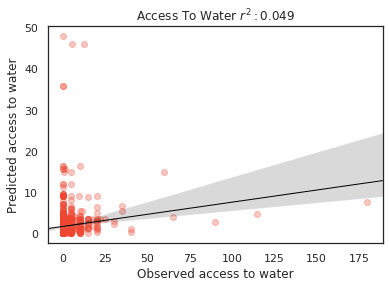

/home/issa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


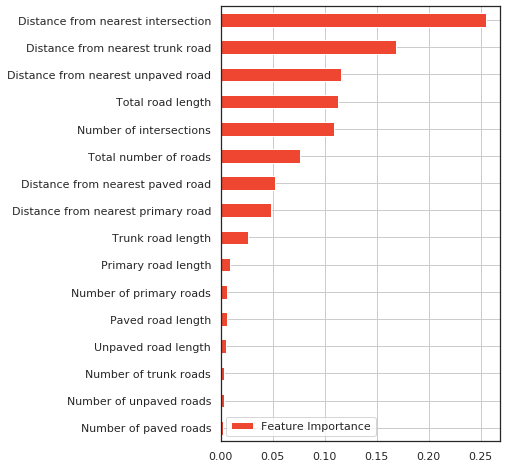

In [9]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=road_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)

## Buildings

Socioeconomic indicator: Wealth Index
fit_time : 88.7304
[88.26436734 88.50879717 89.51897812 88.84970117 88.5101285 ]
score_time : 0.6049
[0.63184047 0.62049747 0.51857686 0.62445903 0.62899184]
test_r2 : 0.5201
[0.51770122 0.55211775 0.52577736 0.5285117  0.47618063]
train_r2 : 0.6423
[0.63612115 0.63668648 0.64303056 0.64265941 0.65320567]
test_rmse : 49156.6530
[49921.26309166 49296.7524424  45786.49462701 49771.50084966
 51007.25420365]
train_rmse : 42619.0200
[42755.34403929 42580.12355497 43254.12592434 42363.19934631
 42142.30720189]


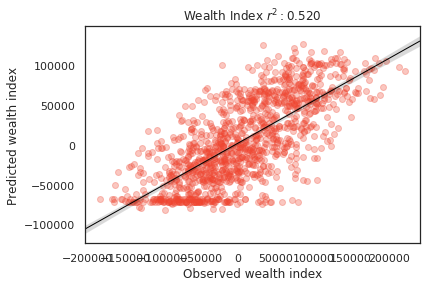

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


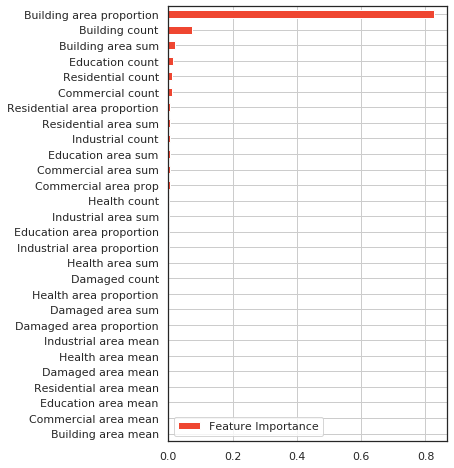

Socioeconomic indicator: Education completed (years)
fit_time : 89.9827
[89.15294647 89.64526749 90.06346846 91.006495   90.04530001]
score_time : 0.5878
[0.63213229 0.62969017 0.63669395 0.42028713 0.6200192 ]
test_r2 : 0.4074
[0.42116032 0.41252086 0.3488425  0.4422686  0.41216998]
train_r2 : 0.5459
[0.53257783 0.54272708 0.56352788 0.5377449  0.55297057]
test_rmse : 1.8092
[1.71670261 1.90322063 1.86709935 1.80457431 1.75455659]
train_rmse : 1.5900
[1.62548257 1.57199381 1.56745018 1.59319577 1.59176811]


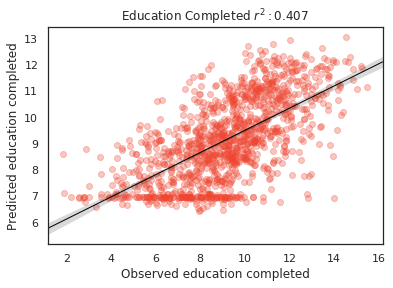

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


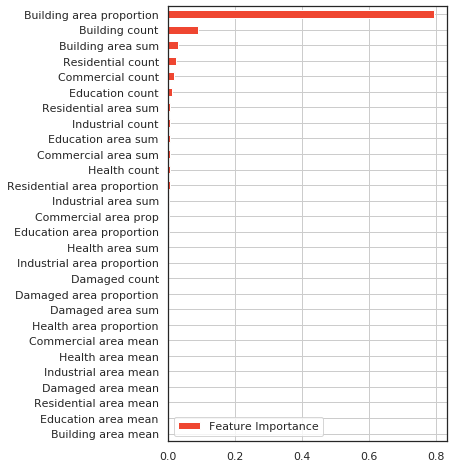

Socioeconomic indicator: Access to electricity
fit_time : 88.9270
[88.83646297 88.70633674 89.21187377 88.81689644 89.0636301 ]
score_time : 0.5261
[0.52683616 0.63195348 0.52189708 0.53220582 0.41773677]
test_r2 : 0.2195
[0.17682278 0.22073901 0.22018995 0.27646171 0.20337674]
train_r2 : 0.3595
[0.36704118 0.35150491 0.36504369 0.34589938 0.36807779]
test_rmse : 0.1280
[0.10721947 0.12286805 0.13661025 0.13840568 0.13499672]
train_rmse : 0.1167
[0.12130693 0.11861782 0.11434417 0.11417892 0.1149555 ]


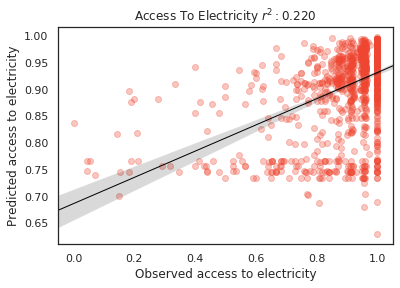

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


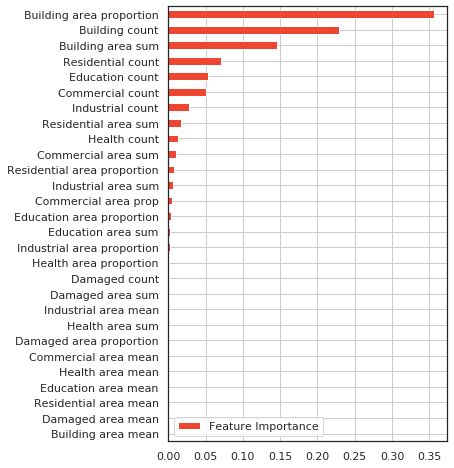

Socioeconomic indicator: Access to water (minutes)
fit_time : 86.6669
[85.8120892  87.54235077 86.29518843 86.96102977 86.72372317]
score_time : 0.4829
[0.42654014 0.6221354  0.42323351 0.41890693 0.52367353]
test_r2 : 0.0396
[0.03055715 0.01713482 0.02622382 0.05955411 0.06446945]
train_r2 : 0.1362
[0.23075081 0.06137345 0.10769408 0.14405405 0.13703165]
test_rmse : 7.5925
[12.88171717  8.20385109  6.62162162  5.00266496  5.25263538]
train_rmse : 7.6898
[5.91593297 7.96086658 8.14560832 8.23077349 8.19560256]


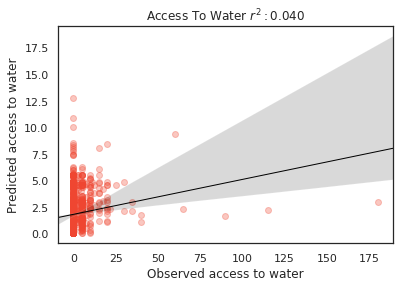

/home/issa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


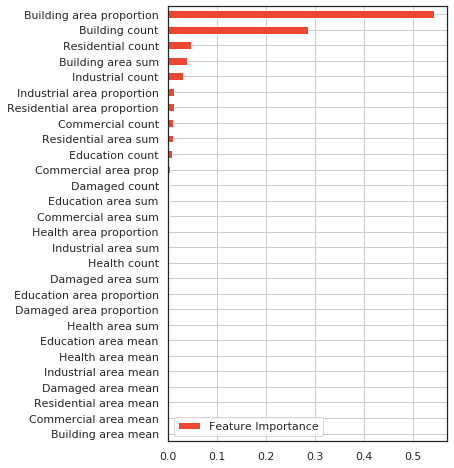

In [10]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=building_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)

## Points of Interest

Socioeconomic indicator: Wealth Index
fit_time : 90.5333
[89.89912939 90.15361094 91.07401991 90.74943471 90.79053974]
score_time : 0.4235
[0.42532635 0.4285996  0.41891599 0.42146969 0.4232533 ]
test_r2 : 0.4930
[0.48576332 0.50240836 0.48364347 0.5257034  0.46756247]
train_r2 : 0.6122
[0.60698059 0.60490689 0.6208549  0.60391323 0.62449922]
test_rmse : 50679.2548
[52055.10310068 52138.46270501 47618.30078773 50470.96037596
 51113.44690349]
train_rmse : 44733.8900
[44915.4301664  44841.71098556 44775.58226413 45097.9381602
 44038.78845818]


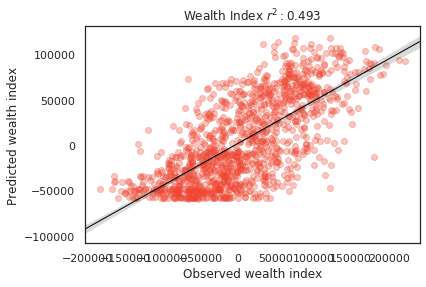

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=6, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1244, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


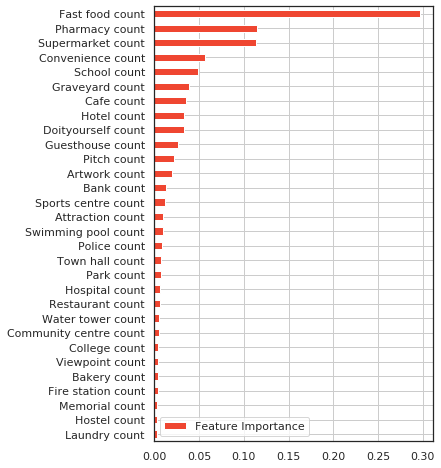

Socioeconomic indicator: Education completed (years)
fit_time : 90.2137
[90.05013633 90.08753085 89.89626861 91.12387609 89.91057944]
score_time : 0.4228
[0.41783118 0.41867709 0.42754102 0.42928886 0.42090273]
test_r2 : 0.3999
[0.40387199 0.38474914 0.34077853 0.46946558 0.40062957]
train_r2 : 0.5180
[0.51732513 0.51965328 0.5329938  0.49996737 0.52019746]
test_rmse : 1.8255
[1.75186509 1.95350481 1.86392257 1.79253083 1.7656094 ]
train_rmse : 1.6498
[1.66459811 1.62115592 1.632059   1.67217716 1.6590081 ]


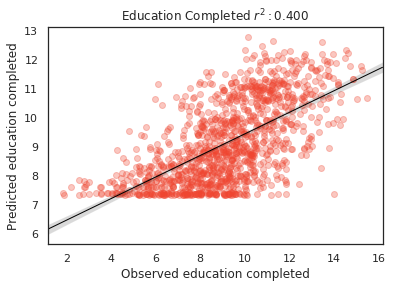

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


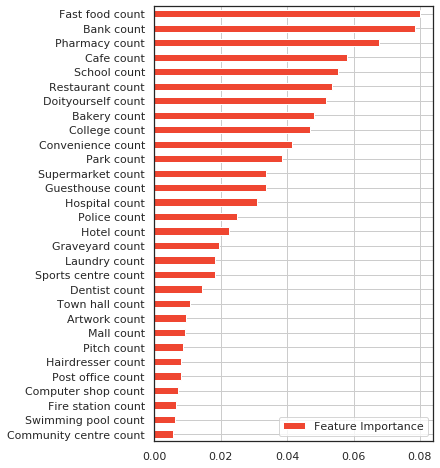

Socioeconomic indicator: Access to electricity
fit_time : 90.2046
[90.8428247  90.30979872 90.23027229 89.96825528 89.67206144]
score_time : 0.4221
[0.42458463 0.42054796 0.42133713 0.41954994 0.42428541]
test_r2 : 0.1959
[0.20260324 0.18860597 0.18650164 0.2362451  0.16532861]
train_r2 : 0.2521
[0.25071692 0.25478257 0.24903059 0.24679127 0.25932636]
test_rmse : 0.1302
[0.10378146 0.12550634 0.14005503 0.14410693 0.13772354]
train_rmse : 0.1264
[0.13232191 0.12763235 0.12457293 0.12287116 0.12474962]


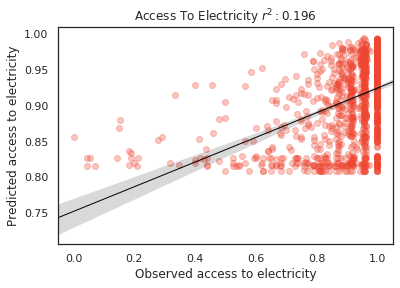

Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=8, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=9, min_samples_split=3,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=764, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


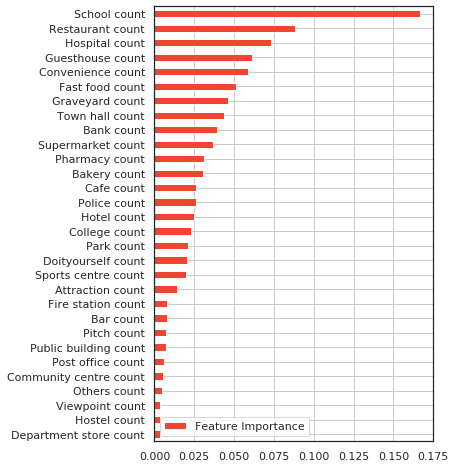

Socioeconomic indicator: Access to water (minutes)
fit_time : 88.1178
[87.07880592 88.44352961 88.24164033 88.14994073 88.67524004]
score_time : 0.4651
[0.42118812 0.44050479 0.41984463 0.41813779 0.62593174]
test_r2 : 0.0538
[0.04432415 0.05460315 0.01326409 0.06173657 0.09520526]
train_r2 : 0.1011
[0.1479197  0.09845529 0.07368231 0.0888652  0.09665937]
test_rmse : 7.5137
[12.82857496  8.06123124  6.69174147  4.84972087  5.13698815]
train_rmse : 7.8169
[6.06768448 7.85380438 8.25196698 8.49154058 8.41956476]


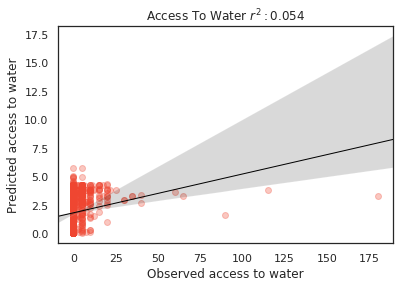

/home/issa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best estimator: Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=False, criterion='mse',
                                       max_depth=7, max_features='log2',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=6, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=969, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


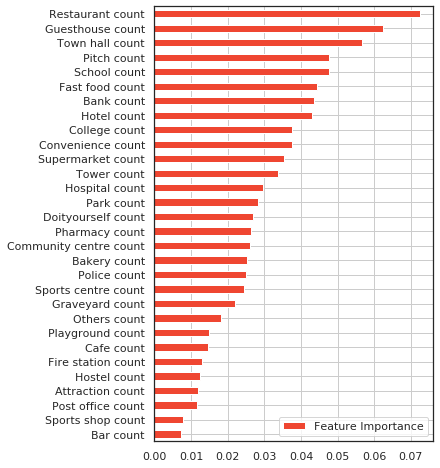

In [11]:
predictions = model_utils.evaluate_model(
    data=dhs,
    feature_cols=poi_cols, 
    indicator_cols=indicators,
    scoring=scoring,
    wandb=None,
    model_type='random_forest', 
    refit='r2', 
    search_type='random', 
    n_splits=5, 
    n_iter=10, 
    plot_importance=True
)